# Gendist V1.0
## Rotation trenches

In [ ]:
import os
from datetime import datetime

date_str = datetime.now().strftime("%y%m%d%H%M")
path_base = f"exp-{date_str}"

path_base = os.path.join("outputs", path_base)
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

print(path_base)

In [11]:
path_base = os.path.join("outputs", "exp-2203140742")
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

In [ ]:
os.mkdir(path_base)
os.mkdir(path_output)
os.mkdir(path_logs)

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from augly import image
from sklearn.decomposition import PCA
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [15]:
from tqdm.notebook import tqdm

In [16]:
import gendist
from gendist import training, processing

In [17]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params
from gendist.training import TrainingConfig, make_cross_entropy_loss_func

In [18]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [19]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [20]:
n_classes = 10
X_train = np.array(mnist_train.data) / 255
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [21]:
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [22]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

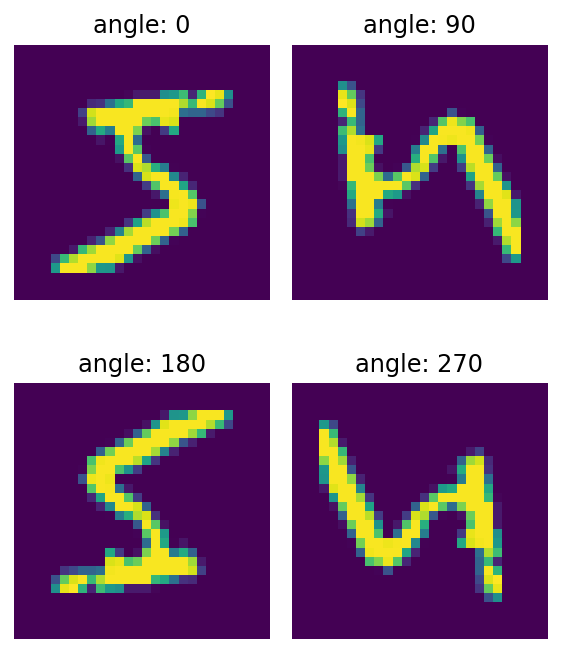

In [23]:
degrees = [0, 90, 180, 270]

fig, ax = plt.subplots(2, 2, figsize=(4, 5))
for axi, deg in zip(ax.flat, degrees):
    x_shift = processor(X_train[0], deg)
    
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"angle: {deg}")
plt.tight_layout()

In [24]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 50
alpha = 0.001
tx = optax.adam(learning_rate=alpha)
model = MLPDataV1(n_classes)

proc_class = gendist.processing.Factory(processor)
degrees = np.r_[np.linspace(0, 90, 50), np.linspace(180, 270, 50)]

In [ ]:
train_config = TrainingConfig(model, proc_class, make_cross_entropy_loss_func, tx)
configs_params = []
configs_accuracy = []
for deg in tqdm(degrees):
    config = {"angle": float(deg)}
    params, train_acc = train_config.train_model_config(key, X_train, y_train_ohe,
                                                        config, n_epochs, batch_size)
    configs_params.append(params)
    configs_accuracy.append(train_acc)

In [61]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

output_elements = {
    "configs": degrees,
    "params": configs_params,
    "metric": configs_accuracy
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [ ]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

with open(filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [26]:
configs_params_flat, fn_recontruct_params = gendist.processing.flat_and_concat_params(configs_params)

In [152]:
configs_params_flat.shape

(100, 1033510)

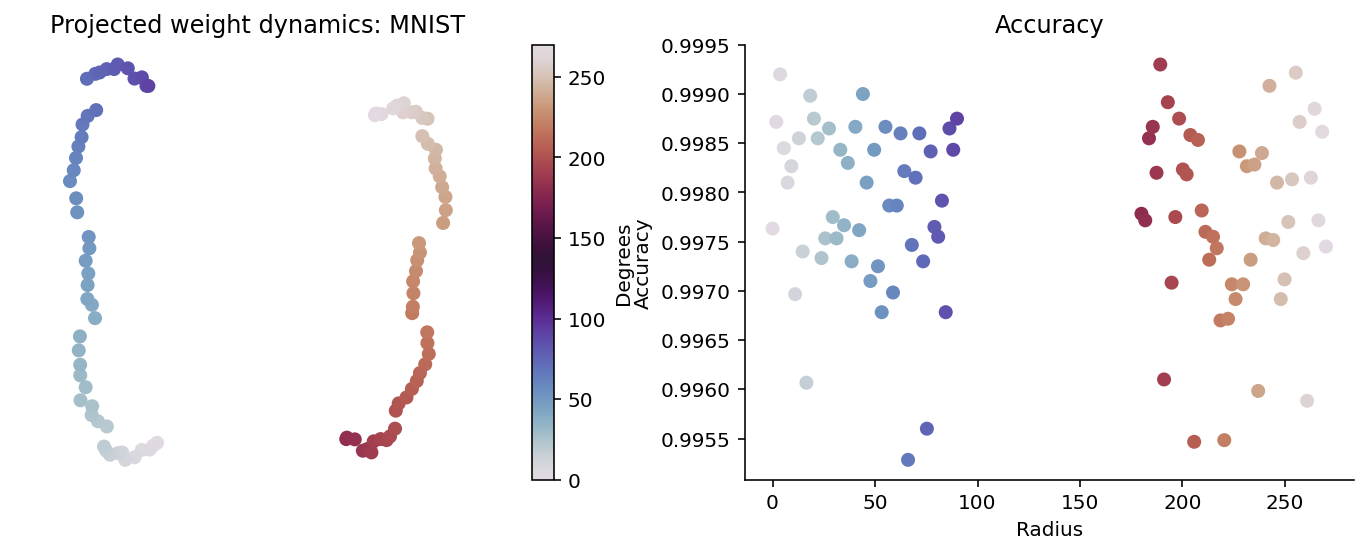

In [27]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
im =  ax[0].scatter(*params_proj.T, c=degrees, cmap="twilight")
fig.colorbar(im, ax=ax[0], label="Degrees")

ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")
ax[0].axis("off")


ax[1].set_title("Accuracy")
ax[1].scatter(degrees, configs_accuracy, c=degrees, cmap="twilight")
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy");

## Training weights

In [154]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

In [155]:
angle_dict = [{"angle": float(deg)} for deg in degrees]

In [156]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [67]:
filename = f"training-weights-dynamics.log"
filename = os.path.join(path_logs, filename)

logger.add(filename, rotation="5mb")
logger.warning("Initialising process")

In [157]:
imap = np.ones((100, 1, 28, 28))
X_train_shift = X_train[subset_ix] * imap
X_train_shift = X_train_shift.reshape(-1, 28, 28)
X_train_shift.shape

tcmalloc: large alloc 3763200000 bytes == 0x55da49858000 @  0x7f36d8d0a680 0x7f36d8d2b824 0x7f36b5edb1ed 0x7f36b5edb267 0x7f36b5f1dc1b 0x7f36b5f1ded8 0x7f36b5fcf177 0x7f36b5fd0dec 0x7f36b6116652 0x55d75cce3e88 0x55d75ce655d8 0x7f36b5fd7ff7 0x55d75cdd1520 0x55d75ce0c568 0x55d75cdc5b32 0x55d75ce75ddc 0x55d75cdc6b5b 0x55d75ceab8fe 0x55d75cda4581 0x55d75cd3e3be 0x55d75cdb6d34 0x55d75ce103ff 0x55d75cdb6d34 0x55d75ce103ff 0x55d75cdb6d34 0x55d75cdc00a3 0x55d75cd3e1a4 0x55d75cdc68c3 0x55d75cd3e3be 0x55d75cdc68c3 0x55d75cd3e1a4


(600000, 28, 28)

In [158]:
degrees_shift = (degrees[:, None] * np.ones((1, 6000))).reshape(-1)
degrees_shift = [{"angle": float(angle)} for angle in degrees_shift]

X_train_shift = proc_class(X_train_shift, degrees_shift)

In [159]:
y_train_shift = params_proj[:, None, :] * np.ones((1, 6000, n_components))
y_train_shift = y_train_shift.reshape(-1, n_components)
y_train_shift.shape

(600000, 60)

In [161]:
alpha = 0.001
tx = optax.adam(learning_rate=alpha)
weights_model = gendist.models.MLPWeightsV1(n_components)
train_weights = TrainingConfig(weights_model, lambda x, _: x, gendist.training.make_multi_output_loss_func, tx)

In [162]:
weights_trained, train_acc = train_weights.train_model_config(key, X_train_shift, y_train_shift,
                                                    None, n_epochs, batch_size)

In [163]:
jnp.power(weights_model.apply(weights_trained, X_train_shift) - y_train_shift, 2).mean()

DeviceArray(11.283924, dtype=float32)

In [145]:
filename = "projected-weights.params"
filename = os.path.join(path_output, filename)

with open(filename, "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [166]:
angle_test = np.linspace(0, 360, 100)

In [23]:
with open(observed_space_filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [24]:
with open("weights-dynamics-rotation-trench.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [168]:
logger.remove()
filename = f"trench-test-c{n_components}.log"
filename = os.path.join(path_logs, filename)
logger.add(filename, rotation="5mb")

2

In [184]:
def predict_shifted_dataset(ix_seed, X_batch, processor, config, wmodel, wparams, dmodel, proj, fn_reconstruct):
    """
    Parameters
    ----------
    ix_seed: array
    X_batch: array
    ...
    wmodel: model for the latent space
    wparams: trained weights for the latent space
    dmodel: model for the observed space
    dparams: trained model for the observed weights
    """
    x_seed = X_batch[ix]
    x_shift = processor.process_single(x_seed, **config).ravel()
    predicted_weights = wmodel.apply(wparams, x_shift)
    predicted_weights = proj.inverse_transform(predicted_weights)
    predicted_weights = fn_reconstruct(predicted_weights)
    
    X_batch_shift = processor(X_batch, config)
    y_batch_hat = dmodel.apply(predicted_weights, X_batch_shift)
    
    return y_batch_hat

In [ ]:
ix = 4
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                         weights_model, weights_trained, model, pca, fn_recontruct_params)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned.item())
    
    predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

In [ ]:
accuracy_configs_learned = []
predicted_weights_array = []

ixs = [0, 1, 2, 3, 4]
for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    acc_dict = {}
    params_dict = {}
    for ix in ixs:
        y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                             weights_model, weights_trained, model, pca, fn_recontruct_params)
        y_test_hat = y_test_hat.argmax(axis=1)
        accuracy_learned = (y_test_hat == y_test).mean().item()
        acc_dict[ix] = accuracy_learned
        
    accuracy_configs_learned.append(acc_dict)
    
    logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
    logger_row = f"{angle=:0.4f} | " + logger_row 
    
    logger.info(logger_row)

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028279 (TID 2028279) on cpu 31 from PID 1951196; stack trace: ***
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028269 (TID 2028269) on cpu 84 from PID 1951196; stack trace: ***
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36c6e317f9,7f36d8b833bf&map=7a511a57244151c993b16b37978e7ed7:7f36b8459000-7f36c719bd50 
E0315 13:27:38.786079 2028279 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domai

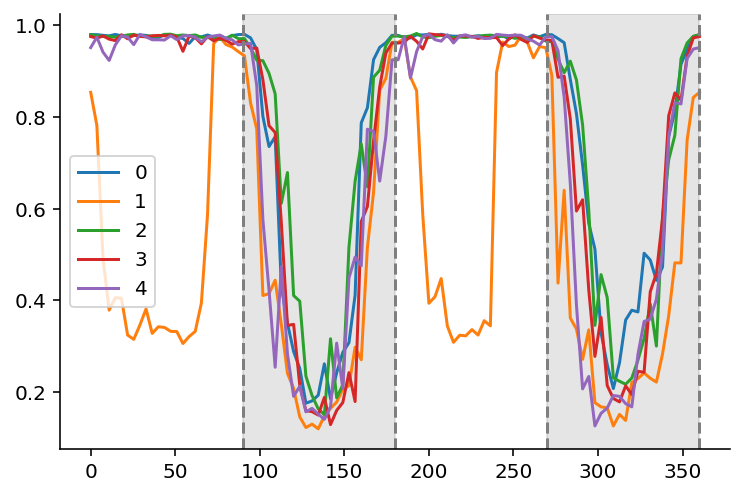

In [228]:
acc_df = pd.DataFrame(accuracy_configs_learned, index=angle_test)
acc_df.plot()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.axvspan(90, 180, alpha=0.2, color="tab:gray")

plt.axvline(x=270, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.axvspan(270, 360, alpha=0.2, color="tab:gray")


We evaluate the predicted weights on the training dataset

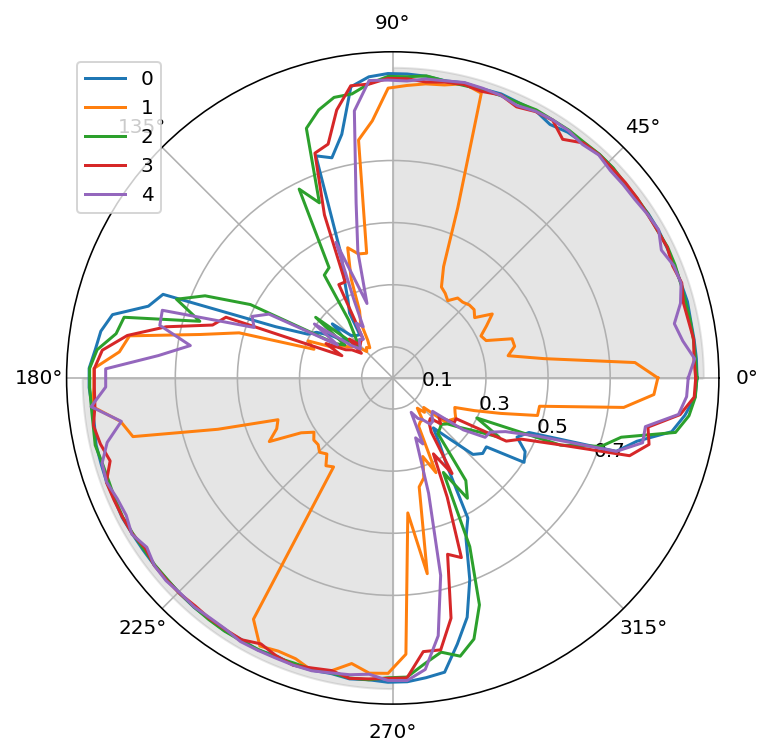

In [238]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
acc_df.set_index(acc_df.index.values * np.pi / 180).plot(ax=ax)
ax.set_rticks([0.1, 0.3, 0.5, 0.7])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.fill_between(np.linspace(0, np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
ax.fill_between(np.linspace(np.pi, 3 * np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")

ax.grid(True)